In [23]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
%matplotlib inline


In [24]:
def parse_tb_logs(nb_folds, metrics_path, metrics_to_plot):
    values = defaultdict(list)

    for fold_nb in range(nb_folds):
        fold_string = f"fold_{fold_nb}"
        print(fold_string,  end = ' ')
        event_acc = EventAccumulator(join(metrics_path, fold_string))
        event_acc.Reload()
        #print(event_acc.Tags())
        for tag in metrics_to_plot:
            try:
                _, step_nums, vals = zip(*event_acc.Scalars(tag))
                print(f'{tag} {len(vals)}, ',  end = '')
                values[tag].append(list(np.around(vals, 4)))
                values[f'{tag}_step'].append(list(step_nums))
                values['fold_nb'].append(fold_nb)
            except:
                print(f"warning: {tag} not in logs")
                pass
        print()
    return values

def interpolate_values(metrics_to_plot, values, tot_num_values=100):
    interp_values = defaultdict(list)

    for metric_name in metrics_to_plot:
        x = np.linspace(0, max(max(values[f'{metric_name}_step'])), num=tot_num_values)
        temp_lists=[]
        for steps, vals in zip(values[f'{metric_name}_step'], values[metric_name]):
            temp_lists.append(np.interp(x, steps, vals))
        interp_values[f'{metric_name}_interp_steps'] = list(x)
        interp_values[f'{metric_name}_interp_mean'] = np.mean(temp_lists, axis=0)
        interp_values[f'{metric_name}_interp_var'] = np.var(temp_lists, axis=0)
    
    return interp_values

def plot_metrics(metrics_to_plot, interp_values_df, ax, label):
    for i, metric_name in enumerate(metrics_to_plot):
        epochs = interp_values_df[f'{metric_name}_interp_steps'] 
        mean_val = interp_values_df[f'{metric_name}_interp_mean']
        var_val = interp_values_df[f'{metric_name}_interp_var']
        ax[i].plot(epochs, mean_val, label=label) #, yerr=var_val)
        ax[i].fill_between(epochs, mean_val-var_val, mean_val+var_val, alpha=0.2, facecolor='k')
        ax[i].set_title(metric_name)
        
    return ax

In [29]:
checkpoints = ['ckpt_27056606_0104_1317_synth_um_b1_d3',
              'ckpt_27056607_0104_1317_synth_um_b100_d3']

metrics_paths = [f"../logs/{ckpt}/metrics_synth/" for ckpt in checkpoints]
nb_fold= 5

metrics_to_plot = ['val_loss', 'val_acc', 'val_ap', 'train_loss_epoch', 'train_acc', 'train_ap']
#metrics_to_plot_dict = {'val_loss': 0, 'val_acc':1, 'val_ap':2, 'train_loss_epoch':3, 'train_acc':4,
#                  'train_ap':5}


ckpt_27056606_0104_1317_synth_um_b1_d3
fold_0 val_loss 45, val_acc 45, val_ap 45, train_loss_epoch 2000, train_acc 2000, train_ap 2000, 
fold_1 val_loss 18, val_acc 18, val_ap 18, train_loss_epoch 2000, train_acc 2000, train_ap 2000, 
fold_2 val_loss 11, val_acc 11, val_ap 11, train_loss_epoch 2000, train_acc 2000, train_ap 2000, 
fold_3 val_loss 9, val_acc 9, val_ap 9, train_loss_epoch 2000, train_acc 2000, train_ap 2000, 
fold_4 val_loss 8, val_acc 8, val_ap 8, train_loss_epoch 2000, train_acc 2000, train_ap 2000, 
ckpt_27056607_0104_1317_synth_um_b100_d3
fold_0 val_loss 45, val_acc 45, val_ap 45, train_loss_epoch 2000, train_acc 2000, train_ap 2000, 
fold_1 val_loss 18, val_acc 18, val_ap 18, train_loss_epoch 2000, train_acc 2000, train_ap 2000, 
fold_2 val_loss 11, val_acc 11, val_ap 11, train_loss_epoch 2000, train_acc 2000, train_ap 2000, 
fold_3 val_loss 9, val_acc 9, val_ap 9, train_loss_epoch 2000, train_acc 2000, train_ap 2000, 
fold_4 val_loss 8, val_acc 8, val_ap 8, train_l

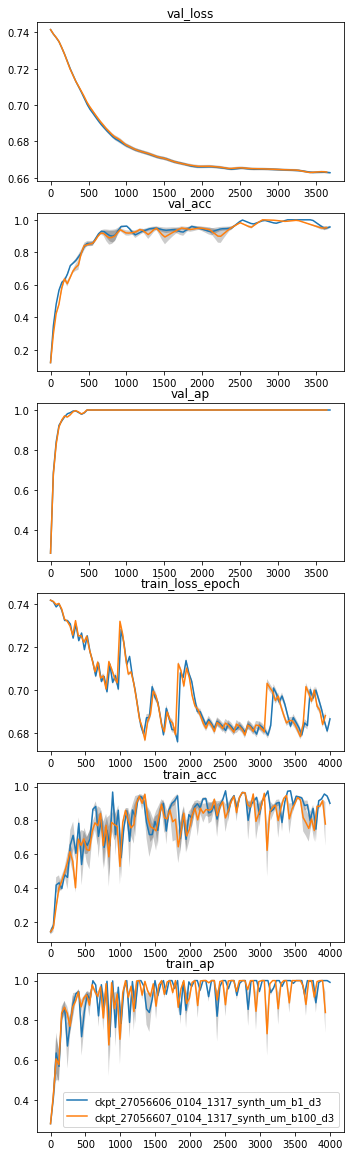

In [30]:
f,a = plt.subplots(len(metrics_to_plot),1)
f.set_size_inches(5,16)
f.tight_layout()
    
for metrics_path, ckpt_name in zip(metrics_paths, checkpoints):
    print(ckpt_name)
    metric_values = parse_tb_logs(nb_fold, metrics_path, metrics_to_plot)
    interp_values = interpolate_values(metrics_to_plot, metric_values, tot_num_values=100)
    interp_values_df = pd.DataFrame(interp_values)
    
    plot_metrics(metrics_to_plot, interp_values_df, a, label=ckpt_name)
    plt.legend()